In [8]:

import numpy as np

import pandas as pd



def generate_population(N, alpha, beta):

    X = np.zeros(N)

    X[N//2:] = 1

    Lambda = np.exp(alpha + beta*X)

    counts = np.random.poisson(Lambda, size=N)

    return pd.DataFrame({"counts": counts, "X": X})


In [9]:
N = 1000
alpha = 0
beta = 1

X = np.zeros(N)
X[N//2:] = 1
Lambda = np.exp(alpha + beta*X)
counts = np.random.poisson(Lambda, size=N)
pd.DataFrame({"counts": counts, "X": X})

# we end up with 1000 items that all come form a Poisson distrbution of parameter lambda that is also apporximated by a Binomila distriubtuo


,counts,X
0,1,0.0
1,0,0.0
2,2,0.0
3,1,0.0
4,0,0.0
...,...,...
995,1,1.0
996,3,1.0
997,1,1.0
998,3,1.0


In [10]:
# Poisson estimated by lambda as a binommial distribution

#!pip install seaborn pymc3

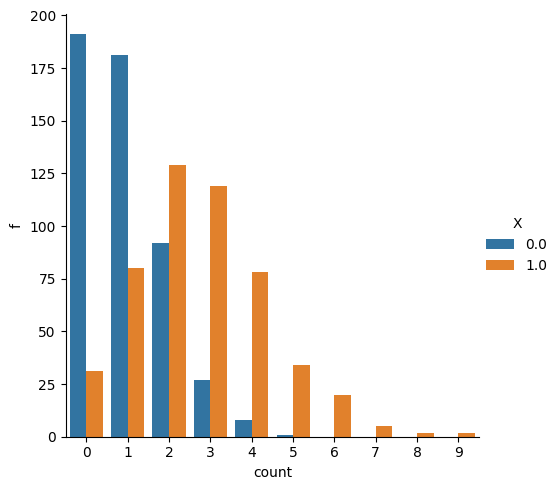

In [11]:
import seaborn as sns 

pop = generate_population(1000, 0, 1)

ax = sns.catplot(
    data=pop.groupby("X")["counts"].value_counts().reset_index(name="f"),
    kind="bar", x="counts", y="f", hue="X")
ax.set(xlabel="count", ylabel="f");

In [12]:
pop

,counts,X
0,0,0.0
1,0,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
995,2,1.0
996,1,1.0
997,3,1.0
998,3,1.0


In [13]:
# We look at the number of times there is the event 0 (= Not seen)

print(f'Total number of missing items is {(pop["counts"] == 0).sum()}')

print(f'Number of missing items with X=1 is {((pop["counts"] == 0) & (pop["X"] == 1)).sum()}')

print(f'Number of missing items with X=0 is {((pop["counts"] == 0) & (pop["X"] == 0)).sum()}')



Total number of missing items is 222
Number of missing items with X=1 is 31
Number of missing items with X=0 is 191


In [14]:
# Now we want to estimate those numbers with the Generalized Chao Estimator --> Objectives

In [15]:
data = pop.copy()[pop["counts"].isin((1, 2))] # we keep f1 and f2
data["y"] = (data["counts"] == 2).astype(int)
data = data.reset_index(drop=True)

In [16]:
import pymc3 as pm

with pm.Model() as model:

    alpha = pm.Normal('alpha', 0, 5)  # prior on alpha

    beta = pm.Normal('beta', 0, 5)  # prior on beta

    p = pm.Deterministic("p", pm.math.invlogit(alpha + beta*data["X"])) # the logit function p

    f2 = pm.Binomial("f2", 1, p, observed=data["y"]) # Binomial distribtuion with probability p

    trace = pm.sample(1000, tune=2000, return_inferencedata=True)


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


KeyboardInterrupt: 

0      0
1      0
2      0
3      0
4      0
      ..
458    1
459    1
460    1
461    0
462    1
Name: y, Length: 463, dtype: int64

In [ ]:
import arviz as az
az.summary(trace, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.588,0.122,-0.815,-0.364,0.003,0.002,1836.0,2090.0,1.0
beta,0.925,0.185,0.588,1.280,0.004,0.003,1885.0,2490.0,1.0


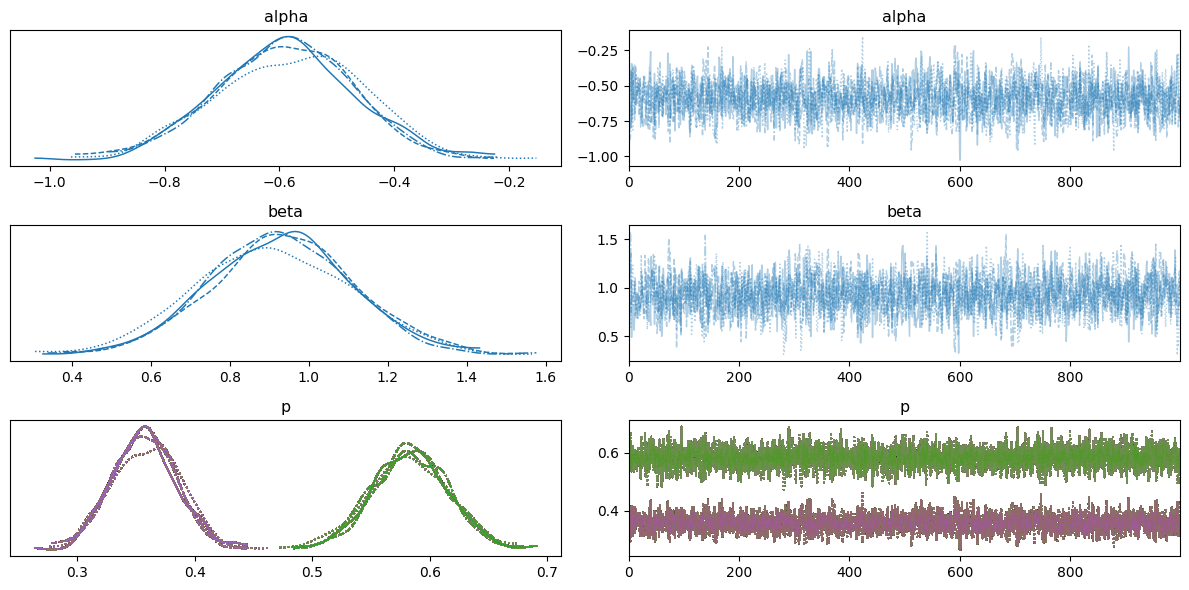

In [ ]:
import matplotlib.pyplot as plt
az.plot_trace(trace)
plt.tight_layout();

In [ ]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, p_dim_0: 513)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * p_dim_0  (p_dim_0) int64 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511 512
Data variables:
    alpha    (chain, draw) float64 -0.55 -0.6101 -0.8148 ... -0.6692 -0.6206
    beta     (chain, draw) float64 0.9369 1.134 1.003 ... 0.8408 1.066 1.005
    p        (chain, draw, p_dim_0) float64 0.3659 0.3659 0.3659 ... 0.595 0.595
Attributes:
    created_at:                 2024-02-28T10:37:22.686801
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              3.3055717945098877
    tuning_steps:               2000

In [ ]:
post = az.extract_dataset(trace) # stack all chains

In [ ]:
n = (pop["counts"] > 0).sum() # number total of observations of 0 and 1

In [ ]:
p = post["p"].values

In [ ]:
l = (2 * p) / (1 - p) #lambda for each sample
f0 = (1 / (l + (l**2) / 2))
N = n + f0.sum(0)

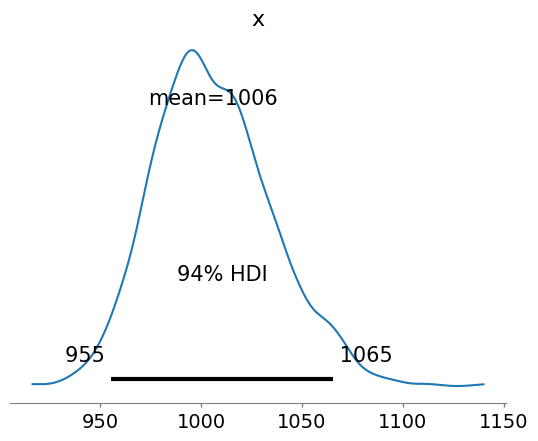

In [ ]:
az.plot_posterior(N, point_estimate="mean");

In [ ]:
import copia

print(round(copia.chao1(pop["counts"])))

970


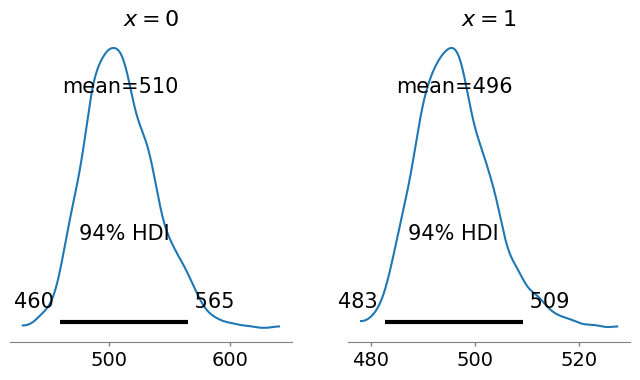

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))



labeller = az.labels.MapLabeller(var_name_map={"x": r"$x=0$"})
n0 = ((pop["counts"] > 0) & (pop["X"] == 0)).sum()
l = (2 * p) / (1 - p)
f0_x0 = (1 / (l + (l**2) / 2)) * (data["X"] == 0).astype(int).values[:, None]
S_x0 = n0 + f0_x0.sum(0)
az.plot_posterior(S_x0, ax=axes[0], labeller=labeller);



labeller = az.labels.MapLabeller(var_name_map={"x": r"$x=1$"})

n1 = ((pop["counts"] > 0) & (pop["X"] == 1)).sum()

l = (2 * p) / (1 - p)

f0_x1 = (1 / (l + (l**2) / 2)) * (data["X"] == 1).astype(int).values[:, None]

S_x1 = n1 + f0_x1.sum(0)


az.plot_posterior(S_x1, ax=axes[1], labeller=labeller);


In [ ]:
N0 = round(copia.chao1(pop.loc[pop["X"] == 0, "counts"]))

N1 = round(copia.chao1(pop.loc[pop["X"] == 1, "counts"]))


print(f"Estimate for N for X=0 equals {N0}")

print(f"Estimate for N for X=1 equals {N1}")

print(f"The sum of the group estimates equals {N0 + N1}.")


Estimate for N for X=0 equals 509
Estimate for N for X=1 equals 496
The sum of the group estimates equals 1005.


In [ ]:
with pm.Model() as intercept_model:

    alpha = pm.Normal('alpha', 0, 5)  # prior on alpha

    p = pm.Deterministic("p", pm.math.invlogit(alpha))

    f2 = pm.Binomial("f2", 1, p, observed=data["y"])

    intercept_trace = pm.sample(1000, tune=2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


In [ ]:
import arviz as az

az.summary(intercept_trace, var_names=["alpha"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.194,0.089,-0.359,-0.026,0.002,0.001,1932.0,2797.0,1.0


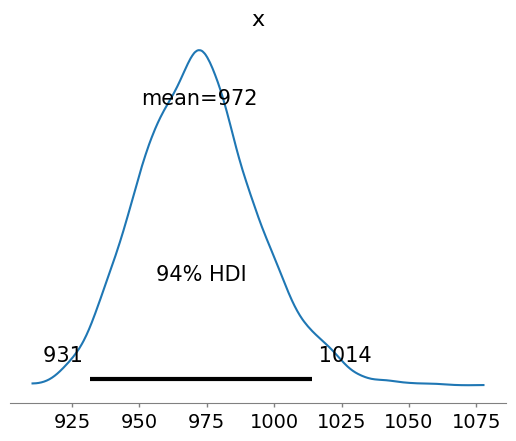

In [ ]:
post = az.extract_dataset(intercept_trace) # stack all chains
n = (pop["counts"] > 0).sum()
nu  = (post["alpha"].values * np.ones(data.shape[0])[:, None])
p = np.exp(nu) / (1 + np.exp(nu))
l = (2 * p) / (1 - p)
f0 = (1 / (l + (l**2) / 2))
N = n + f0.sum(0)

az.plot_posterior(N, point_estimate="mean");

In [ ]:
loo_comparison = az.compare(
    {
        "covariate-model": trace,
        "intercept-model": intercept_trace,
    })


InvalidIndexError: You can only assign a scalar value not a <class 'tuple'>